# **Andrew Han, RedVentures Data Science Product Manager Take-home Assessment**

We would love to understand your data and machine learning technical skills, critical thinking on the business problem and insights at hand, and ability to derive actionable insights. Through this case, please provide a notebook of your choice (Jupyter, Colab, etc.), including your code, your written analysis and explanation for each question, and any visualizations you deem appropriate or relevant. Use appropriate modeling techniques, data analysis and visualization techniques to support your findings. There is an appendix with images and a data dictionary at the end of the doc. Thank you in advance for participating in the case study and enjoy! 

In [6]:
import pandas as pd

#read csv file into pandas
df = pd.read_csv('_28For_Candidate_29_dspm_case_data_set_-__28For_Candidate_29_dspm_case_data_set.csv')


**Part 1: Explore the split test. Tell us what happened**
Possible things to consider: evaluate relevant metrics for the CTA combinations - which CTA Copy and CTA Placement did the best/worst? If we called one of these CTA combinations our champion (serve it 100% of the time), how much incrementally is that worth to us vs. the average of the rest of the split test? 

**How I want to approach this problem**:
* The goal is to identify the best-performing combination of the relevant metrics, like clickedCTA, scheduledAppointment, revenue, etc.


In [21]:
#create a pivot table with multi-level indexing on columns
pivot_table = df.pivot_table(
    values=['clickedCTA', 'scheduledAppointment', 'revenue'],
    index=['ctaCopy', 'ctaPlacement'],
    aggfunc={
        'clickedCTA': 'mean',
        'scheduledAppointment': 'mean',
        'revenue': 'mean'
    }
)
#reset index to flatten df
pivot_table.reset_index(inplace=True)

#convert values to percentages
# CTR = Click-through rate
#ARPU = Average Revenue Per User
pivot_table['CTR (%)'] = pivot_table['clickedCTA'] * 100
pivot_table['Conversion Rate (%)'] = pivot_table['scheduledAppointment'] * 100
pivot_table['ARPU'] = pivot_table['revenue']

#drop unnecessary columns
pivot_table.drop(columns=['clickedCTA', 'scheduledAppointment', 'revenue'], inplace=True) 

#sort pivot values and find combination of CTA copy and placement with highest click-through rate
best_cta = pivot_table.sort_values(by='CTR (%)', ascending=False).head(1)
print("\nBest CTA Combination based on CTR:")
print(best_cta)

#sort values to find best CTA combination with highest revenue
best_revenue = pivot_table.sort_values(by='ARPU', ascending=False).head(1)
print("\nBest CTA Combination based on Revenue:")
print(best_revenue)


Best CTA Combination based on CTR:
                                        ctaCopy ctaPlacement    CTR (%)  \
8  Get Pre-Approved for a Mortgage in 5 Minutes          Top  21.175306   

   Conversion Rate (%)       ARPU  
8             6.029518  12.680886  

Best CTA Combination based on Revenue:
                                             ctaCopy ctaPlacement    CTR (%)  \
3  First Time? We've Made it Easy to Find the Bes...       Bottom  15.309153   

   Conversion Rate (%)       ARPU  
3             5.688057  12.905229  


Now to visualize what we found by exploring the pivot table, I will make a heatmap using seaborn and matplotlib of different copy/placement combinations and their corresponding click-through rates.

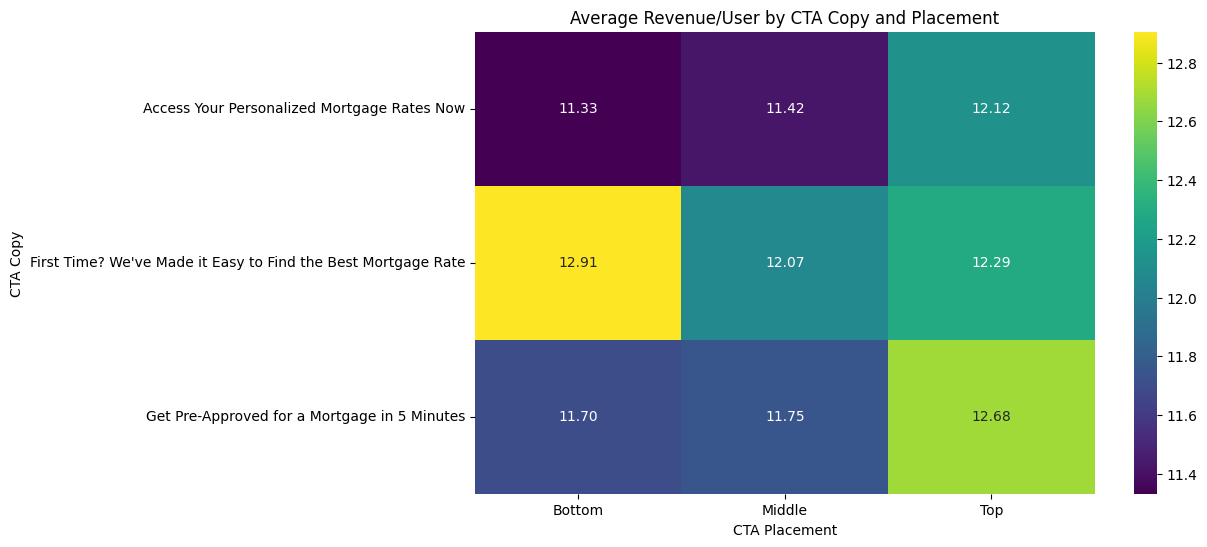

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap for CTR
heatmap_data = pivot_table.pivot(index='ctaCopy', columns='ctaPlacement', values='ARPU')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Average Revenue/User by CTA Copy and Placement')
plt.xlabel('CTA Placement')
plt.ylabel('CTA Copy')
plt.show()


Using this heatmap, suppose we decide to use the 'First Time? We've Made it Easy to Find the Best Mortgage Rate' Copy and Bottom placement for it has the highest average revenue per user value. To assess the incremental value of serving this combination to all users compared to the average performance of the other combinations, I will use the following code:

In [36]:
#create 
performance_summary = df.groupby(['ctaCopy', 'ctaPlacement']).agg({
    'clickedCTA': 'mean',
    'scheduledAppointment': 'mean',
    'revenue': 'mean'
}).reset_index()

best_performer = performance_summary.loc[performance_summary['revenue'].idxmax()]

best_copy = best_performer['ctaCopy']
best_placement = best_performer['ctaPlacement']
best_revenue = best_performer['revenue']

avg_revenue_others = df[
    (df['ctaCopy'] != best_copy) | (df['ctaPlacement'] != best_placement)
]['revenue'].mean()

incremental_value = (best_revenue - avg_revenue_others) * len(df)

print("\nIncremental value of Best Combination: ${0:,.2f}".format(incremental_value))


Incremental value of Best Combination: $98,423.77


**Part 2: Tell us about the site users and their behavior**\
Possible things to consider: Which groups of people tend to be more correlated or less correlated with our key metrics? Are there groups of people who drove higher/lower numbers when engaging with specific CTA copies and placements? What ways can you manipulate the columns/dataset to create features that increase predictive power towards our key metrics?


For this part, I want to examine the relationships between different user groups and metrics such as:
* deviceType
* browser
* estimatedAnnualIncome
* estimatedPropertyType
* visitCount
* scrolledPage
* scrollDepth

And see how the different users respond to different combinations of CTA copies and placements.

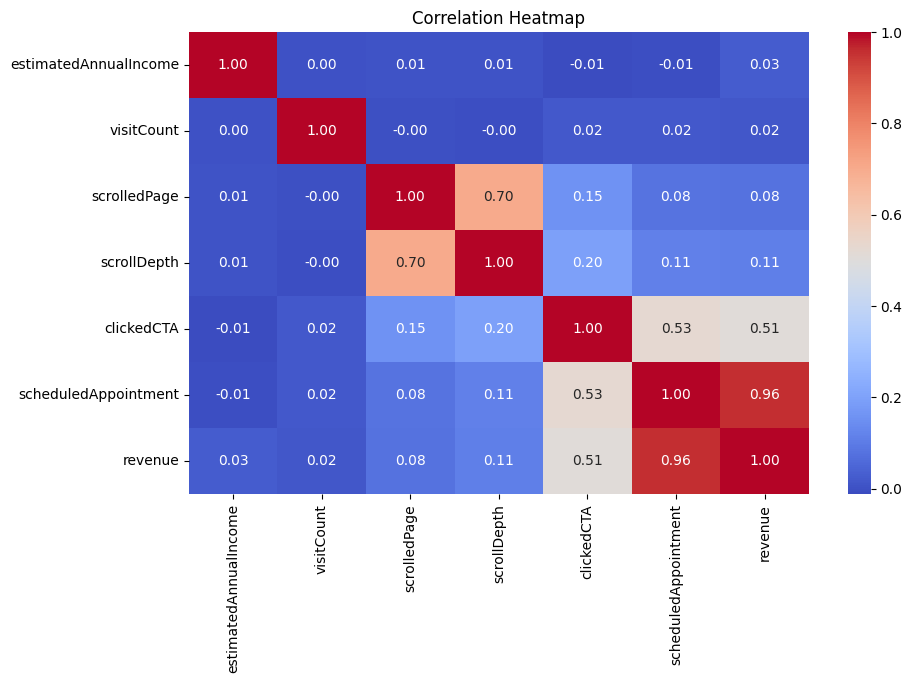

In [37]:

#calculate correlation matrix for numeric features
corr_matrix = df[['estimatedAnnualIncome', 'visitCount', 'scrolledPage', 'scrollDepth', 'clickedCTA', 'scheduledAppointment', 'revenue']].corr()

#plotting the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**Insights from Heatmap**
* High correlation between visitCount and scheduledAppointment or clickedCTA, which may indicate frequent site visitors are more likely to schedule an appointment.
* Strong correlation between scrollDepth and clickedCTA, showing that users who scroll further down the page may show interest in the website.
* Low to moderate correlation between estimatedAnnualIncome and clickedCTA, indicating that either income is not a strong factor in whether users click the CTA or not.

Now let's look into user behavior across the different CTA copy and placement combinations.

<Figure size 1400x800 with 0 Axes>

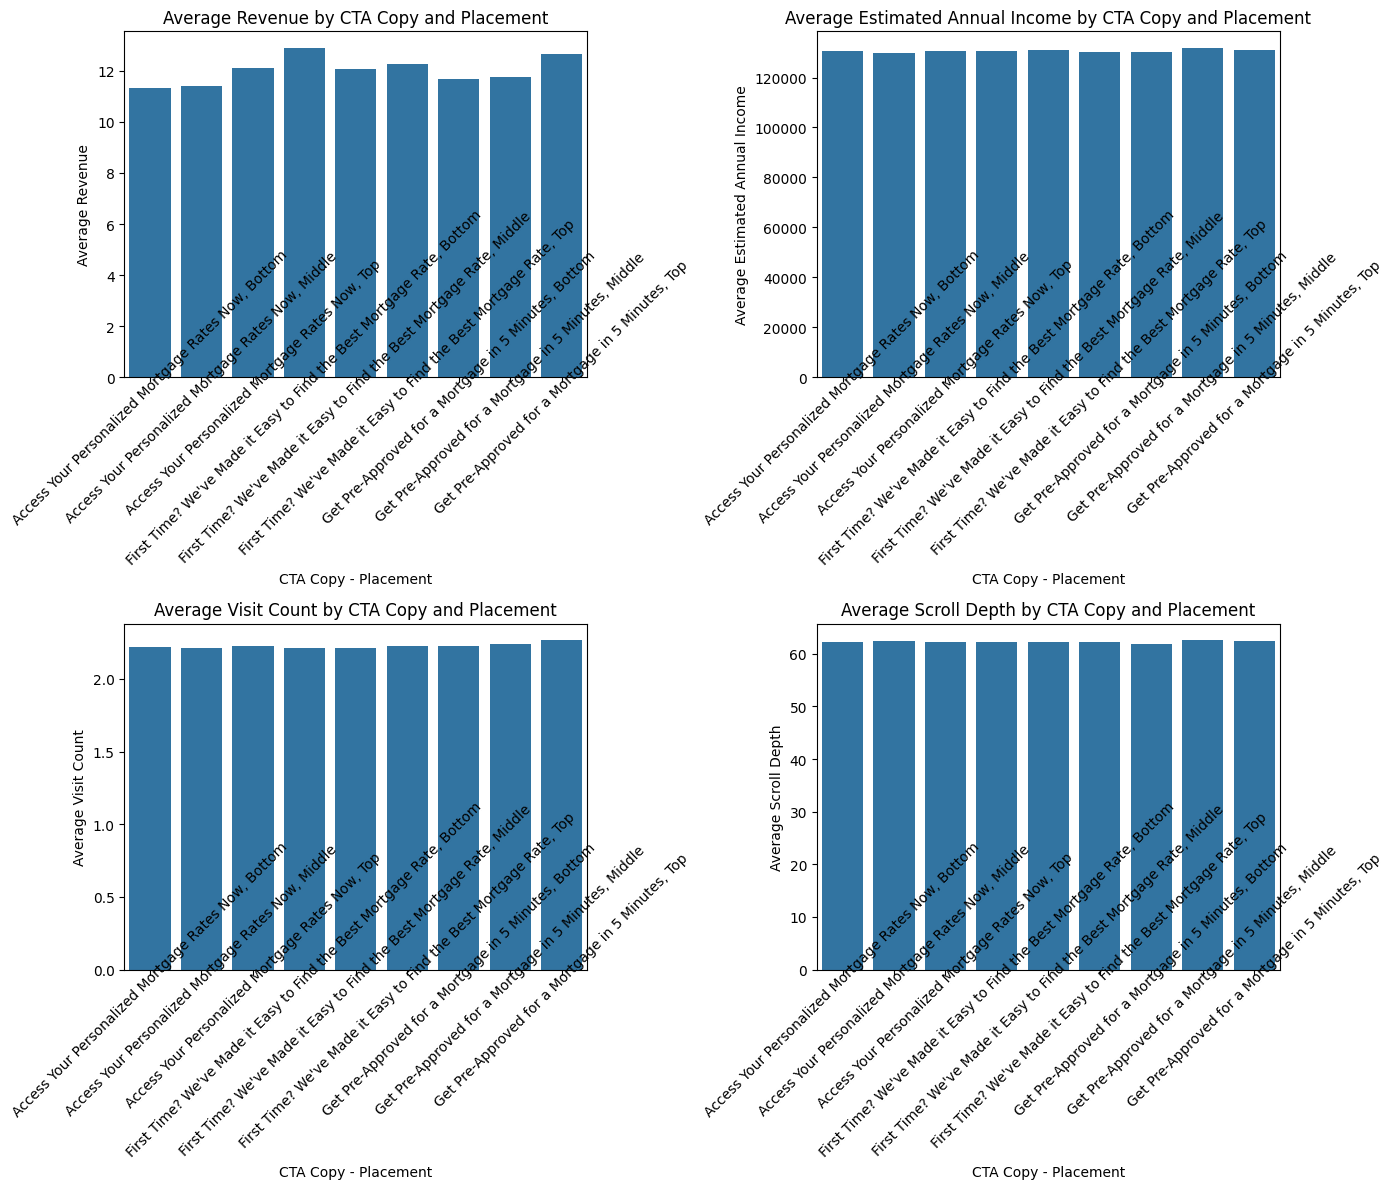

In [73]:
#group by CTA Copy and Placement, and calculate the mean of relevant metrics
cta_user_metrics = df.groupby(['ctaCopy', 'ctaPlacement']).agg({
    'revenue': 'mean', 
    'estimatedAnnualIncome': 'mean', 
    'visitCount': 'mean', 
    'scrollDepth': 'mean'
}).reset_index()

#combine CTA copy and placement into a single column
cta_user_metrics['cta_combination'] = cta_user_metrics['ctaCopy'] + ', ' + cta_user_metrics['ctaPlacement']

plt.figure(figsize=(14, 8))
#create subplots
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

#plot Revenue vs CTA combination
sns.barplot(x='cta_combination', y='revenue', data=cta_user_metrics, ax=ax[0, 0])
ax[0, 0].set_title('Average Revenue by CTA Copy and Placement')
ax[0, 0].set_xlabel('CTA Copy - Placement')
ax[0, 0].set_ylabel('Average Revenue')
ax[0, 0].tick_params(axis='x', rotation=45)
for label in ax[0, 0].get_xticklabels():
    label.set_horizontalalignment('center')  
    label.set_verticalalignment('center')    

#plot Estimated Annual Income vs CTA combination
sns.barplot(x='cta_combination', y='estimatedAnnualIncome', data=cta_user_metrics, ax=ax[0, 1])
ax[0, 1].set_title('Average Estimated Annual Income by CTA Copy and Placement')
ax[0, 1].set_xlabel('CTA Copy - Placement')
ax[0, 1].set_ylabel('Average Estimated Annual Income')
ax[0, 1].tick_params(axis='x', rotation=45)
for label in ax[0, 1].get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')

#plot Visit Count vs CTA combination
sns.barplot(x='cta_combination', y='visitCount', data=cta_user_metrics, ax=ax[1, 0])
ax[1, 0].set_title('Average Visit Count by CTA Copy and Placement')
ax[1, 0].set_xlabel('CTA Copy - Placement')
ax[1, 0].set_ylabel('Average Visit Count')
ax[1, 0].tick_params(axis='x', rotation=45)
for label in ax[1, 0].get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')

# Plot Scroll Depth vs CTA combination
sns.barplot(x='cta_combination', y='scrollDepth', data=cta_user_metrics, ax=ax[1, 1])
ax[1, 1].set_title('Average Scroll Depth by CTA Copy and Placement')
ax[1, 1].set_xlabel('CTA Copy - Placement')
ax[1, 1].set_ylabel('Average Scroll Depth')
ax[1, 1].tick_params(axis='x', rotation=45)
for label in ax[1, 1].get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')

#adjustments for better readability
plt.tight_layout()
plt.show()


From the graphs, we can see that there is only noticeable variance in the Average Revenue by CTA Copy and Placement.